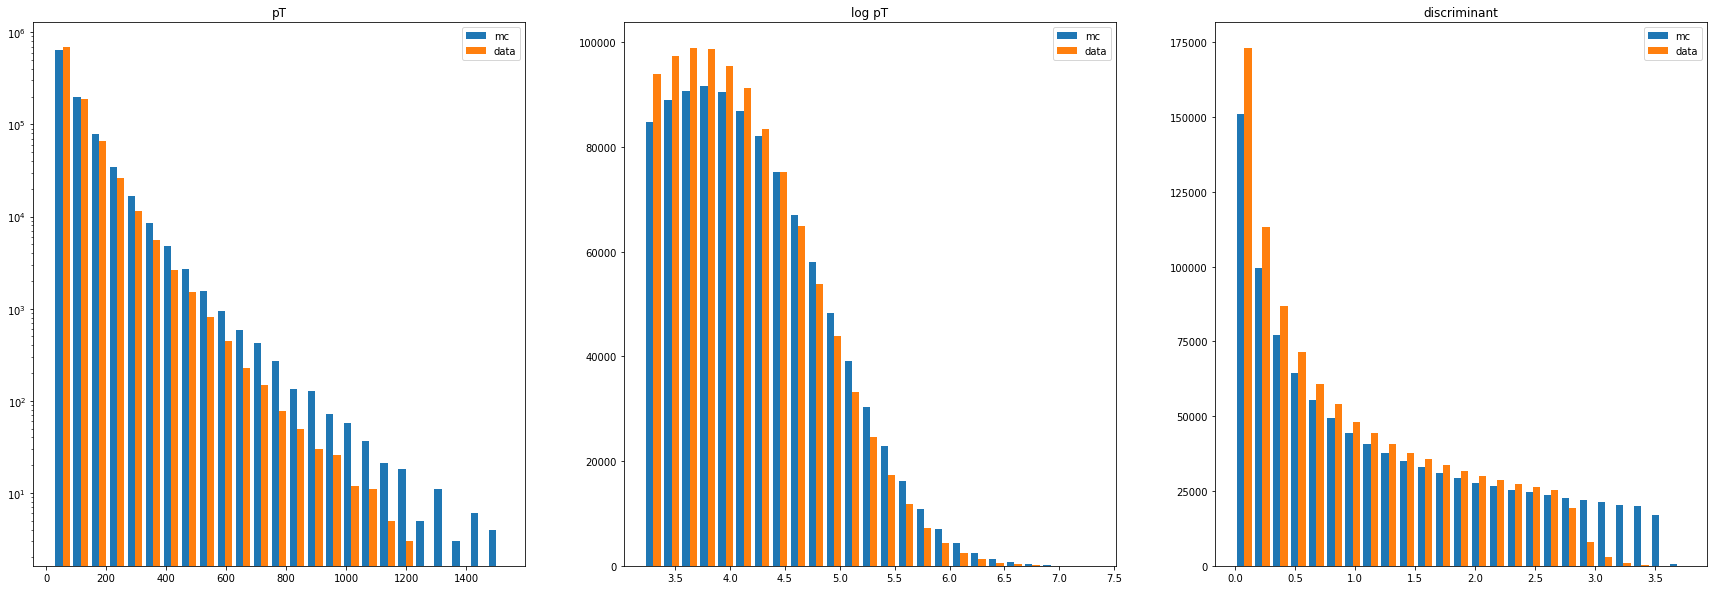

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.special import lambertw

device='cuda'


def poly(cs, xs):
  ys = torch.zeros_like(xs)
  for (i, c) in enumerate(cs):
    ys += c * xs**i

  return ys


def discMC(xs, logpts):
  return poly([0, 0.6, 1.2, 1.1], xs) * poly([1, 0.1, -0.01], logpts)

def discData(xs, logpts):
  return poly([0, 0.7, 1.1, 1.3], xs) * poly([1, -0.1, 0.02], logpts)


def logptMC(xs):
  return torch.log(poly([25, 50, 7], -torch.log(xs)))

def logptData(xs):
  return torch.log(poly([25, 45, 5], -torch.log(xs)))



def bootstrap(n):
  xs = np.random.rand(n)
  ws = lambertw((xs-1)/np.e, k=-1).astype(np.float)
  return - torch.from_numpy(ws).to(device) - 1


# need to add a small number to avoid values of zero.
def genMC(n):
  xs = torch.rand(n, device=device) + 1e-5
  logpts = logptMC(xs)
  ys = torch.rand(n, device=device) + 1e-5
  ds = discMC(ys, logpts)
  return torch.stack([ds, logpts]).transpose(0, 1)

def genData(n):
  xs = torch.rand(n, device=device) + 1e-5
  logpts = logptData(xs)
  ys = torch.rand(n, device=device) + 1e-5
  ds = discData(ys, logpts)
  return torch.stack([ds, logpts]).transpose(0, 1)


def test(n):
  mc = genMC(n).cpu().numpy()
  data = genData(n).cpu().numpy()

  plt.figure(figsize=(30, 10))

  plt.subplot(1, 3, 1)

  _ = plt.hist([np.exp(mc[:,1]), np.exp(data[:,1])], bins=25, label=["mc", "data"])
  plt.title("pT")
  plt.yscale("log")
  plt.legend()

  plt.subplot(1, 3, 2)


  _ = plt.hist([mc[:,1], data[:,1]], bins=25, label=["mc", "data"])
  plt.title("log pT")
  plt.legend()

  plt.subplot(1, 3, 3)

  _ = plt.hist([mc[:,0], data[:,0]], bins=25, label=["mc", "data"])
  plt.title("discriminant")
  plt.legend()
  plt.show()

test(int(1e6))

In [2]:
import torch.nn as nn
from collections import OrderedDict

    
    
nps = 2
nlayer = 0
lnlatent = 8
lnlatentadv = 9

tlr = 5e-6
alr = 5e-5


def layer(n, m):
  return \
    nn.Sequential(
        nn.Linear(n, m)
      , nn.LeakyReLU(inplace=True)
    )


def sequential(xs):
    d = OrderedDict()
    for (i, x) in enumerate(xs):
        d[str(i)] = x
        
    return nn.Sequential(d)



transport = \
  nn.Sequential(
    nn.Linear(2, 2**lnlatent)
  , nn.LeakyReLU(inplace=True)
  , sequential([layer(2**lnlatent, 2**lnlatent) for i in range(nlayer)])
  , nn.Linear(2**lnlatent, 1+nps)
  )


adversary = \
  nn.Sequential(
    nn.Linear(2, 2**lnlatentadv)
  , nn.LeakyReLU(inplace=True)
  , sequential([layer(2**lnlatentadv, 2**lnlatentadv) for i in range(2)])
  , nn.Linear(2**lnlatentadv, 1)
  )




transport.to(device)
adversary.to(device)


def tloss(xs):
  return torch.mean(xs**2)


toptim = torch.optim.Adam(transport.parameters(), lr=tlr)
aoptim = torch.optim.Adam(adversary.parameters(), lr=alr)

new = True

transport

Sequential(
  (0): Linear(in_features=2, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.01, inplace=True)
  (2): Sequential()
  (3): Linear(in_features=256, out_features=3, bias=True)
)

In [3]:
def save():
  torch.save(
      { 'transport_state_dict' : transport.state_dict()
      , 'adversary_state_dict' : adversary.state_dict()
      , 'toptim_state_dict' : toptim.state_dict()
      , 'aoptim_state_dict' : aoptim.state_dict()
      }
    , "./OTCalib.gaus.pth"
  )

def load():
  checkpoint = torch.load("./OTCalib.gaus.pth")
  transport.load_state_dict(checkpoint["transport_state_dict"])
  adversary.load_state_dict(checkpoint["adversary_state_dict"])
  toptim.load_state_dict(checkpoint["toptim_state_dict"])
  aoptim.load_state_dict(checkpoint["aoptim_state_dict"])

In [4]:
from torch.nn.functional import binary_cross_entropy_with_logits
from torch.utils.tensorboard import SummaryWriter
from math import log, exp

# if not new:
#   load()

new = False

writer = SummaryWriter()


def tonp(xs):
  return xs.cpu().detach().numpy()


def plotPtTheta(pt, toys, writer, label, epoch):
  logpt = log(pt)

  zeros = torch.zeros((toys.size()[0], nps), device=device)
  logpts = torch.ones(toys.size()[0], device=device)*logpt

  data = torch.stack([torch.sort(discData(toys, logpts))[0], logpts]).transpose(0, 1)
  mc = torch.stack([torch.sort(discMC(toys, logpts))[0], logpts]).transpose(0, 1)

  thetas = zeros.clone()
  transporting = trans(mc, thetas)
  nomtrans = tonp(transporting)
  nom = tonp(transporting + mc[:,0:1])

  postrans = []
  negtrans = []
  for i in range(nps):
    thetas = zeros.clone()
    thetas[:,i] = 1
    transporting = trans(mc, thetas)
    postrans.append(tonp(transporting))

    thetas = zeros.clone()
    thetas[:,i] = -1
    transporting = trans(mc, thetas)
    negtrans.append(tonp(transporting))


  data = tonp(data)
  mc = tonp(mc)

  fig = plt.figure(figsize=(6, 6))

  rangex = (0, 5)
  rangey = (-1, 1)

  h, b, _ = plt.hist( \
        [mc[:,0], nom[:,0], data[:,0]]
      , bins=25
      , range=rangex
      , density=True
      , label=["mc", "nominal transported", "data"]
      )
  
  plt.title("discriminant distribution, (pT = %0.2f)" % exp(logpt))
  plt.xlabel("discriminant")
  plt.legend()
    
  writer.add_figure("%shist" % label, fig, global_step=epoch)
  plt.close()

    
  fig = plt.figure(figsize=(6, 6))

  _ = plt.plot( \
        (b[:-1] + b[1:]) / 2.0
      , h[0] - h[2]
      , label="mc"
      , linewidth=3
      )

  _ = plt.plot( \
        (b[:-1] + b[1:]) / 2.0
      , h[1] - h[2]
      , label="transported"
      , linewidth=3
      )

  plt.ylim(-0.5, 0.5)
  plt.title("discriminant difference to data, (pT = %0.2f)" % exp(logpt))
  plt.xlabel("discriminant")
  plt.ylabel("prediction - data")
  plt.legend()
    
  writer.add_figure("%sdiff" % label, fig, global_step=epoch)
  plt.close()
    


  fig = plt.figure(figsize=(6, 6))
  
  cols = ["blue", "green", "red", "orange", "magenta"]
  for i in range(nps):
    _ = \
      plt.plot(
          mc[:,0]
        , postrans[i]
        , c=cols[i]
      )

    _ = \
      plt.plot(
          mc[:,0]
        , negtrans[i]
        , c=cols[i]
      )


  _ = \
    plt.plot(
        mc[:,0]
      , nomtrans
      , c="black"
      , lw=4
    )


  
  plt.xlim(rangex)
  plt.ylim(rangey)
  plt.title("discriminant transport, (pT = %0.2f)" % exp(logpt))
  plt.xlabel("mc discriminant")
  plt.ylabel("transport vector")
    

        
  writer.add_figure("%strans" % label, fig, global_step=epoch)
  plt.close()
    
  return


  # plt.show()

  # print("\n\n")
    

torch.autograd.set_detect_anomaly(False)

# toys for validation samples
nval = int(2**15)
valtoys = torch.rand(nval, device=device)


nepochs = 2**20
batchsize = 2**8

datasize = 2**20

alldata = genData(datasize)
allmc = genMC(datasize)

nbatches = datasize // batchsize


def trans(mc, thetas):
    tmp = transport(mc)
    cv = tmp[:,0].unsqueeze(1)
    coeffs = tmp[:,1:]
    
    corr = torch.bmm(thetas.unsqueeze(1), coeffs.unsqueeze(2))
        
    return cv + corr.squeeze(2)
    


for epoch in range(nepochs):
  radvloss = 0
  fadvloss = 0
  tadvloss = 0
  ttransloss = 0
  realavg = 0
  fakeavg = 0
    
  print("epoch:", epoch)
    
  for batch in range(nbatches):

    tmp = alldata[torch.randint(alldata.size()[0], size=(batchsize,), device=device)]
    data = tmp
    
    tmp = allmc[torch.randint(allmc.size()[0], size=(batchsize,), device=device)]
    mc = tmp

    toptim.zero_grad()
    aoptim.zero_grad()

    real = adversary(data)
    realavg += torch.mean(real).item()
    
    tmp1 = \
      binary_cross_entropy_with_logits( \
          real
        , torch.ones_like(real)
        , reduction='mean'
        )

    radvloss += tmp1.item()

    # add gradient regularization
    grad_params = torch.autograd.grad(tmp1, adversary.parameters(), create_graph=True, retain_graph=True)
    grad_norm = 0
    for grad in grad_params:
        grad_norm += grad.pow(2).sum()
    grad_norm = grad_norm.sqrt()
        
    thetas = torch.randn((batchsize, nps), device=device)
    transporting = trans(mc, thetas)
    
    transported = transporting + mc[:,0:1]
    
    fake = adversary(torch.cat([transported, mc[:,1:]], axis=1))


    fakeavg += torch.mean(fake).item()

    

    tmp2 = \
      binary_cross_entropy_with_logits( \
          fake
        , torch.zeros_like(real)
        , reduction='mean'
        )
      
    fadvloss += tmp2.item()

    loss = tmp1 + tmp2 + 0.1*grad_norm

    loss.backward()
    aoptim.step()

    
    

    toptim.zero_grad()
    aoptim.zero_grad()

    thetas = torch.randn((batchsize, nps), device=device)
    transporting = trans(mc, thetas)
    
    transported = transporting + mc[:,0:1]
    fake = adversary(torch.cat([transported, mc[:,1:]], axis=1))

    tmp1 = tloss(transporting)
    ttransloss += tmp1.item()

    tmp2 = \
      binary_cross_entropy_with_logits( \
          fake
        , torch.ones_like(real)
        , reduction='mean'
        )
      
    tadvloss += tmp2.item()

    loss = tmp2 # tmp1 + tmp2

    loss.backward()
    toptim.step()
    

  # write tensorboard info once per epoch
  writer.add_scalar('radvloss', radvloss / nbatches, epoch)
  writer.add_scalar('fadvloss', fadvloss / nbatches, epoch)
  writer.add_scalar('tadvloss', tadvloss / nbatches, epoch)
  writer.add_scalar('ttransloss', ttransloss / nbatches, epoch)
  writer.add_scalar('realavg', realavg / nbatches, epoch)
  writer.add_scalar('fakeavg', fakeavg / nbatches, epoch)


  # make validation plots once per epoch
  plotPtTheta(25, valtoys, writer, "pt25", epoch)
    
  plotPtTheta(100, valtoys, writer, "pt100", epoch)
    
  plotPtTheta(500, valtoys, writer, "pt500", epoch)
    
  save()


epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17


KeyboardInterrupt: 

In [ ]:
save()